In [64]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.stem import WordNetLemmatizer, PorterStemmer
import string
import nltk
nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import  accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
df=pd.read_csv('/content/bbc_news.csv')
df = df.iloc[::-1]
df.reset_index(drop=True,inplace=True)
df=df[['title','link','description']]
df.tail(1)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,title,link,description
25301,Ukraine: Angry Zelensky vows to punish Russian...,https://www.bbc.co.uk/news/world-europe-606380...,The Ukrainian president says the country will ...


In [57]:

def extract_category_subcategory_with_contains(url):
    try:
        # Check for specific keywords in the URL and classify accordingly
        if 'news/business' in url.lower():
            return 'Business'
        elif 'sport/football' in url.lower():
            return 'Sport'
        elif 'news/health' in url.lower():
            return 'Health'
        elif 'news/world' in url.lower():
            return 'World'
    except AttributeError:
        # This handles cases where the URL is not a string (e.g., NaN values)
        pass
    return 'Unknown'



In [58]:
df['link']=df['link'].apply(extract_category_subcategory_with_contains)

In [59]:
df.head(3)

,title,link,description
0,Israel says it will allow two trucks of fuel a...,World,Mobile phone and internet connections have rep...
1,Israel orders Khan Younis evacuation in southe...,World,The area hosts hundreds of thousands of people...
2,March reaches Jerusalem calling for release of...,World,"Protesters walked from Tel Aviv to Jerusalem, ..."


In [60]:
df['title']=df['title']+df['description']
df.drop('description',inplace=True, axis=1)
df.iloc[0,0]

'Israel says it will allow two trucks of fuel a day into GazaMobile phone and internet connections have reportedly been partially restored after a fuel delivery.'

In [61]:
df['link'].replace('Category',inplace=True)
df = df[df['link'] != 'Unknown']
df.tail(3)

,title,link
25299,Ukraine war 'catastrophic for global food'One ...,Business
25300,War in Ukraine: Taking cover in a town under a...,World
25301,Ukraine: Angry Zelensky vows to punish Russian...,World


In [62]:
business_df=df[df['link']=='Business'][0:1000]
sports_df=df[df['link']=='Sport'][0:1000]
health_df=df[df['link']=='Health'][0:1000]
world_df=df[df['link']=='World'][0:1000]
final_df = pd.concat([business_df, sports_df, health_df, world_df], ignore_index=True)
final_df.shape

(3539, 2)

In [63]:
final_df.rename(columns={'link': 'Category'}, inplace=True)
final_df.columns

Index(['title', 'Category'], dtype='object')

In [65]:


# Split the data into training, validation, and test sets
train_df, test_df = train_test_split(final_df, test_size=0.3, random_state=42, stratify=final_df['Category'])
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42, stratify=test_df['Category'])

# Initialize a lemmatizer and a stemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = ''.join([char for char in text if char not in string.punctuation and not char.isdigit()])
    # Tokenization (split the text into words)
    tokens = text.split()
    # Remove stopwords and perform lemmatization followed by stemming
    tokens = [stemmer.stem(lemmatizer.lemmatize(token)) for token in tokens if token not in ENGLISH_STOP_WORDS]
    return ' '.join(tokens)

# Apply preprocessing to each title in the training, validation, and test sets
train_df['title'] = train_df['title'].apply(preprocess_text)
val_df['title'] = val_df['title'].apply(preprocess_text)
test_df['title'] = test_df['title'].apply(preprocess_text)

# Display the first few rows of the preprocessed training, validation, and test sets
print(train_df.head(), val_df.head(), test_df.head())


                                                  title Category
3285  la vega sphere look insid new venu timerock ba...    World
1701  viniciu jr valencia fine given partial stadium...    Sport
1721  newcastl unit brighton hove albion magpi boost...    Sport
2510  crimeancongo haemorrhag fever case uka woman r...   Health
2095  mother awak hour son care break downnh serious...   Health                                                   title Category
3111  man plead guilti steal wizard oz rubi slippers...    World
3321  viktor sokolov russian video show black sea fl...    World
3304  haiti crisi kenyan polic offic defeat gangsth ...    World
2471  child hepat case fals link covid vaccinenon af...   Health
1261  barcelona real beti barca la ligachampion barc...    Sport                                                   title  Category
2945  bobi world oldest dog dy age guin world record...     World
3306  sweden gang pm summon armi chief surg killings...     World
2461  ambul wait time 

In [66]:

# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=5000)

# Initialize the Logistic Regression model
model = LogisticRegression(random_state=42, max_iter=1000)

# Create a pipeline that first applies the vectorizer and then fits the model
pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', model)
])

# Train the model using the training data
pipeline.fit(train_df['title'], train_df['Category'])

# Predict the labels for the validation set
val_predictions = pipeline.predict(val_df['title'])

# Calculate the accuracy and display the classification report for the validation set
accuracy = accuracy_score(val_df['Category'], val_predictions)
classification_rep = classification_report(val_df['Category'], val_predictions, target_names=final_df['Category'].unique())

print(f'Accuracy: {accuracy}')



Accuracy: 0.9378531073446328


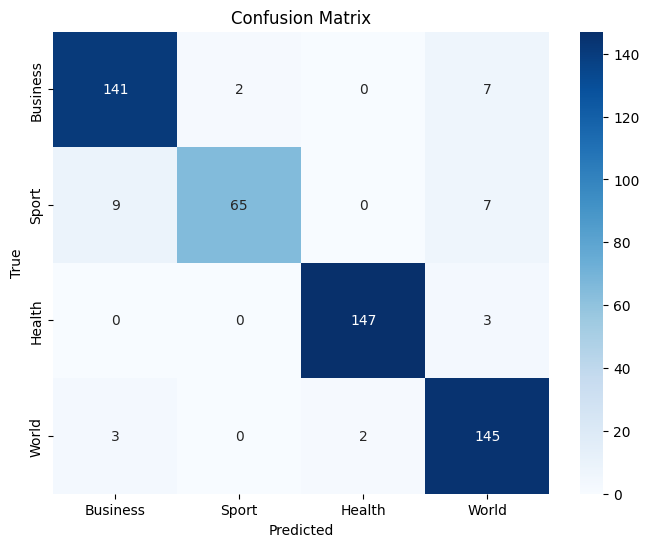

In [68]:
# confusion matrix
confusion_mat = confusion_matrix(val_df['Category'], val_predictions)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=final_df['Category'].unique(), yticklabels=final_df['Category'].unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [69]:
def classify_user_input():
    # Take user input
    user_input = input("Please enter the text you want to classify: ")

    # Preprocess the user input
    processed_input = preprocess_text(user_input)

    # Predict the category using the trained pipeline
    predicted_category = pipeline.predict([processed_input])[0]

    return predicted_category

# Call the function and print the result
print("Predicted Category: ", classify_user_input())


Please enter the text you want to classify: 'My father wasn’t released, but I’m happy for those families'
Predicted Category:  World
